### This kernel experiments with various data augmentation techniques for facial keypoint detection.

In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import cv2
from math import sin, cos, pi
from time import strftime
from datetime import datetime

from tensorflow import keras
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import random
import tensorflow as tf
from tqdm.notebook import tqdm

In [2]:
epochs = 10
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

#make some random data
reset_random_seeds()

### Augmentation & Hyperparameter Settings
#### Experiment with various augmentation choices

In [3]:
horizontal_flip = False
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True

include_unclean_data = True    # Whether to include samples with missing keypoint values. Note that the missing values would however be filled using Pandas' 'ffill' later.
sample_image_index = 20    # Index of sample train image used for visualizing various augmentations

rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

NUM_EPOCHS = 500
BATCH_SIZE = 450

## Reading inputs to a Pandas DataFrame

In [4]:
%%time

idlookup_file = 'data/IdLookupTable.csv'
train_data = pd.read_csv('data/training.csv') 
test_data = pd.read_csv('data/test.csv')
Id_data = pd.read_csv(idlookup_file)

CPU times: user 1.66 s, sys: 180 ms, total: 1.84 s
Wall time: 1.85 s


#### Function to plot facial keypoints with images

In [5]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

### Check for any images with missing pixel values

In [6]:
print("Length of train data: {}".format(len(train_data)))
print("Number of Images with missing pixel values: {}".format(len(train_data) - int(train_data.Image.apply(lambda x: len(x.split())).value_counts().values)))

Length of train data: 7049
Number of Images with missing pixel values: 0


### Find columns having Null values and their counts

In [7]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

#### We can observe that approx. 68% of data is missing for several keypoints

In [8]:
%%time

clean_train_data = train_data.dropna()
print("clean_train_data shape: {}".format(np.shape(clean_train_data)))

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape: {}\n".format(np.shape(unclean_train_data)))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)

CPU times: user 12.1 ms, sys: 40 µs, total: 12.2 ms
Wall time: 10.1 ms


### Separate data into clean & unclean subsets

Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)

CPU times: user 15.1 s, sys: 1.36 s, total: 16.5 s
Wall time: 16.5 s


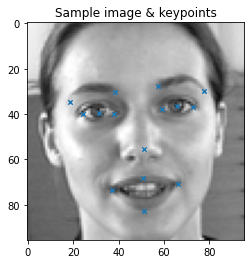

In [9]:
%%time

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Sample image & keypoints")

if include_unclean_data:
    unclean_train_images = load_images(unclean_train_data)
    print("Shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("Shape of unclean_train_keypoints: {}\n".format(np.shape(unclean_train_keypoints)))
    train_images = np.concatenate((train_images, unclean_train_images))
    train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

## Performing Horizontal Flipping for Data Augmentation

In [10]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

## Performing Rotation Augmentation

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



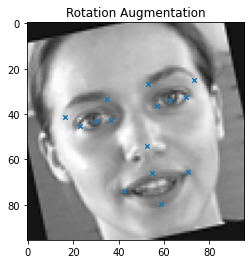

In [11]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

## Performing Brightness Alteration for Data Augmentation

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


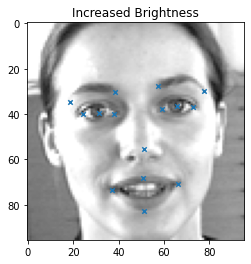

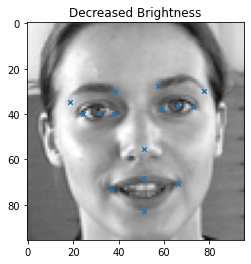

In [12]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness") 

## Performing Horizontal & Vertical shift

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


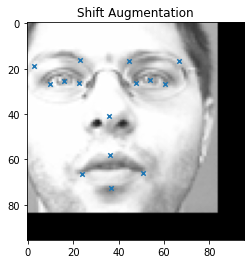

In [13]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

## Adding Random Noise for Data Augmentation

Shape of noisy_train_images: (2140, 96, 96, 1)


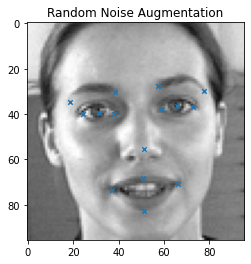

In [14]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random Noise Augmentation")

## Visualize Train images & corresponding Keypoints

Shape of final train_images: (26239, 96, 96, 1)
Shape of final train_keypoints: (26239, 30)

 Clean Train Data: 


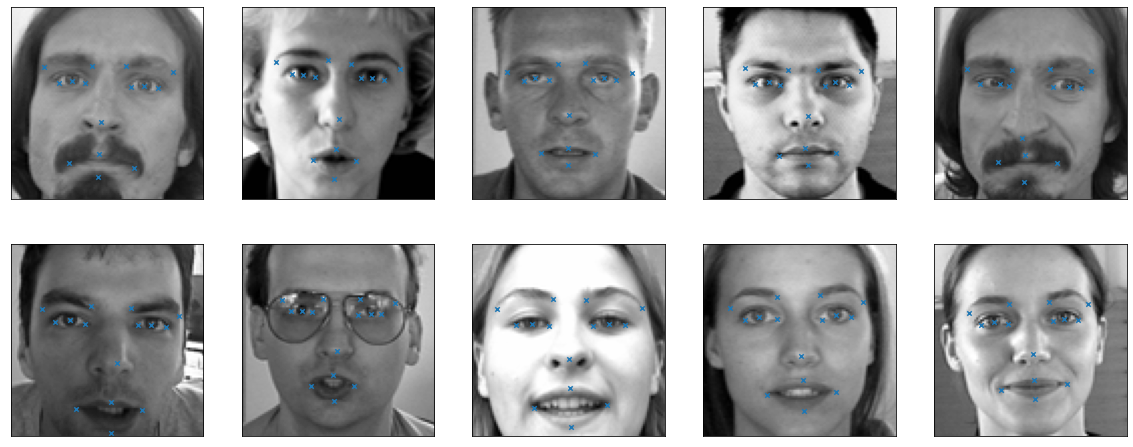

Unclean Train Data: 


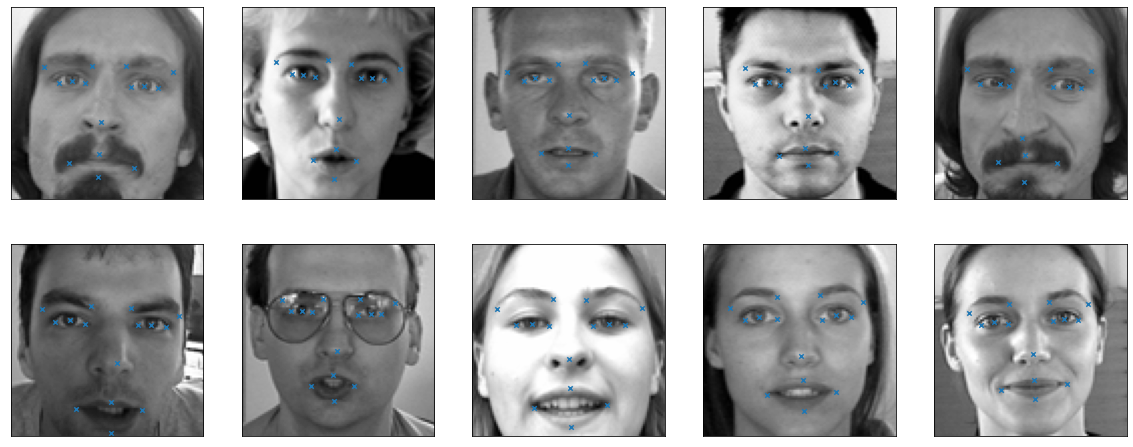

Rotation Augmentation: 


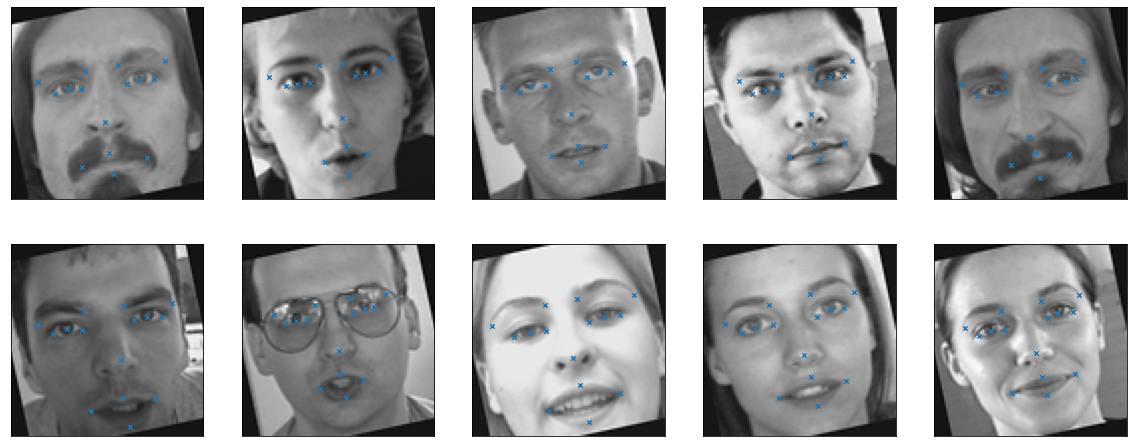

Brightness Augmentation: 


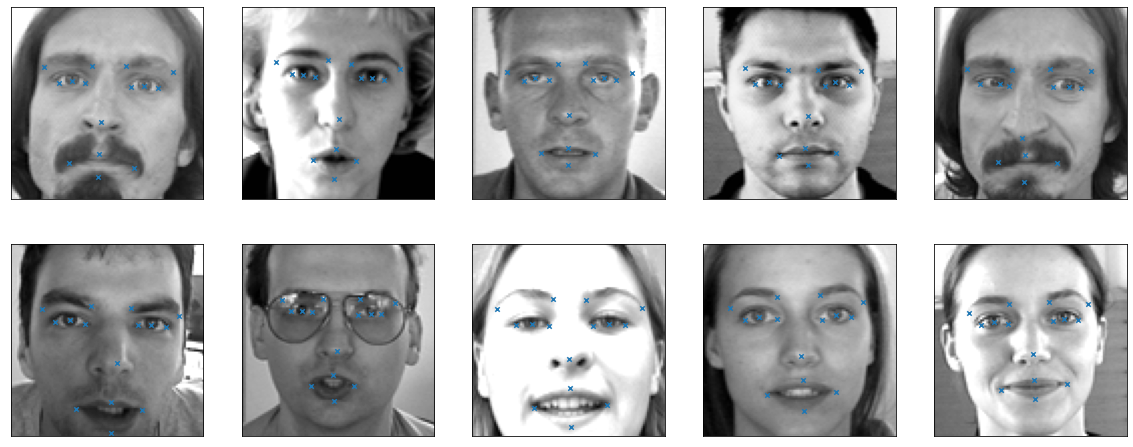

Shift Augmentation: 


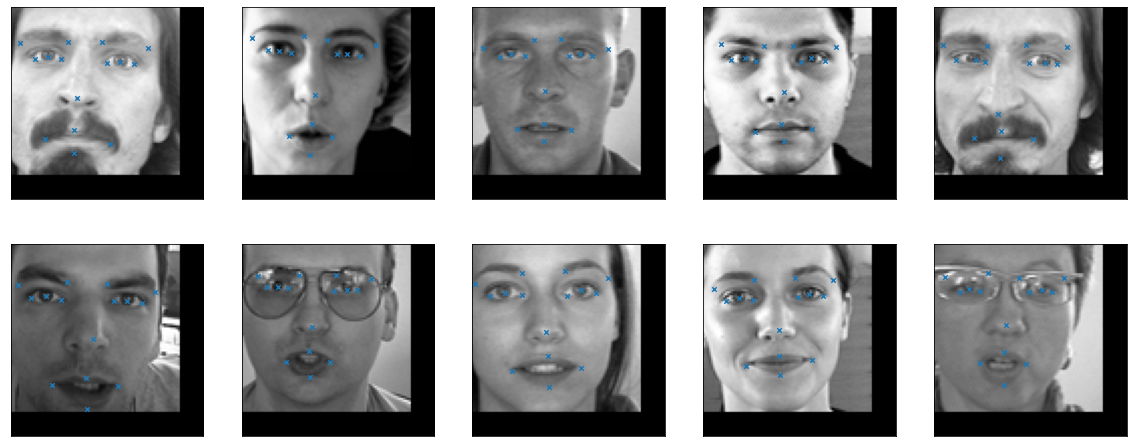

Random Noise Augmentation: 


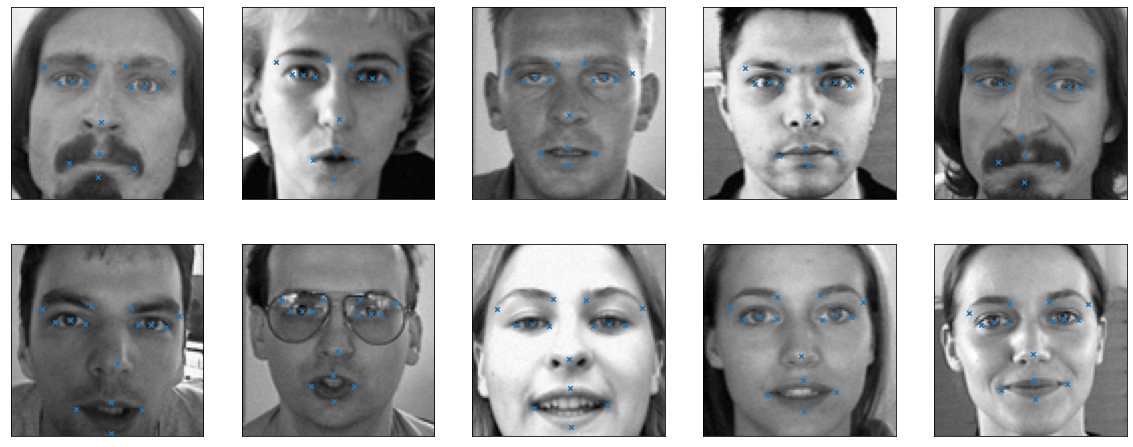

In [15]:
print("Shape of final train_images: {}".format(np.shape(train_images)))
print("Shape of final train_keypoints: {}".format(np.shape(train_keypoints)))

print("\n Clean Train Data: ")
# fig = plt.figure(figsize=(20,8))
# for i in range(10):
#     axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#     plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
# plt.show()

# if include_unclean_data:
#     print("Unclean Train Data: ")
#     fig = plt.figure(figsize=(20,8))
#     for i in range(10):
#         axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#         plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
#     plt.show()

# if horizontal_flip:
#     print("Horizontal Flip Augmentation: ")
#     fig = plt.figure(figsize=(20,8))
#     for i in range(10):
#         axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#         plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
#     plt.show()

# if rotation_augmentation:
#     print("Rotation Augmentation: ")
#     fig = plt.figure(figsize=(20,8))
#     for i in range(10):
#         axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#         plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
#     plt.show()
    
# if brightness_augmentation:
#     print("Brightness Augmentation: ")
#     fig = plt.figure(figsize=(20,8))
#     for i in range(10):
#         axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#         plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
#     plt.show()

# if shift_augmentation:
#     print("Shift Augmentation: ")
#     fig = plt.figure(figsize=(20,8))
#     for i in range(10):
#         axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#         plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
#     plt.show()
    
# if random_noise_augmentation:
#     print("Random Noise Augmentation: ")
#     fig = plt.figure(figsize=(20,8))
#     for i in range(10):
#         axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#         plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
#     plt.show()

## Building a model

In [16]:
model = Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 48, 48, 32)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 48, 48, 64)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 12, 12, 96)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 12, 12, 128)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 6, 6, 128)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 6, 6, 256)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

## Training the model

In [17]:
start_time = datetime.now()
# Load a pre-trained model (if present)
if os.path.exists('/data/models/data-augmentated-6block_2FC/best_model.hdf5'):
    model = load_model('/data/models/data-augmentated-6block_2FC/best_model.hdf5')

# Define necessary callbacks
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

# Train the model
history = model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.05, callbacks=[checkpointer])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/500
56/56 [==============================] - ETA: 0s - loss: 172.8187 - mae: 8.2476 - acc: 0.3735
Epoch 00001: val_mae improved from inf to 10.82839, saving model to best_model.hdf5
56/56 [==============================] - 25s 439ms/step - loss: 172.8187 - mae: 8.2476 - acc: 0.3735 - val_loss: 161.4833 - val_mae: 10.8284 - val_acc: 0.6174
Epoch 2/500
56/56 [==============================] - ETA: 0s - loss: 25.5515 - mae: 3.9452 - acc: 0.4876
Epoch 00002: val_mae improved from 10.82839 to 7.90341, saving model to best_model.hdf5
56/56 [==============================] - 22s 399ms/step - loss: 25.5515 - mae: 3.9452 - acc: 0.4876 - val_loss: 85.8790 - val_mae: 7.9034 - val_acc: 0.6189
Epoch 3/500
56/56 [==============================] - ETA: 0s - loss: 19.5422 - mae: 3.4380 - acc: 0.5172
Epoch 00003: val_mae improved from 7.90341 to 6.22248, saving model to best_model.hdf5
56/56 [==============================] - 22s 397ms/step - loss: 19.5422 - mae: 3.4380 - acc: 0.5172 - val_loss

Epoch 25/500
56/56 [==============================] - ETA: 0s - loss: 6.0570 - mae: 1.8855 - acc: 0.8002
Epoch 00025: val_mae did not improve from 1.01567
56/56 [==============================] - 22s 393ms/step - loss: 6.0570 - mae: 1.8855 - acc: 0.8002 - val_loss: 1.9030 - val_mae: 1.0449 - val_acc: 0.7995
Epoch 26/500
56/56 [==============================] - ETA: 0s - loss: 5.7863 - mae: 1.8438 - acc: 0.8038
Epoch 00026: val_mae improved from 1.01567 to 0.91518, saving model to best_model.hdf5
56/56 [==============================] - 23s 403ms/step - loss: 5.7863 - mae: 1.8438 - acc: 0.8038 - val_loss: 1.5035 - val_mae: 0.9152 - val_acc: 0.8247
Epoch 27/500
56/56 [==============================] - ETA: 0s - loss: 6.3476 - mae: 1.9266 - acc: 0.8085
Epoch 00027: val_mae did not improve from 0.91518
56/56 [==============================] - 22s 401ms/step - loss: 6.3476 - mae: 1.9266 - acc: 0.8085 - val_loss: 2.2507 - val_mae: 1.1532 - val_acc: 0.7790
Epoch 28/500
56/56 [================

56/56 [==============================] - ETA: 0s - loss: 3.9346 - mae: 1.5085 - acc: 0.8567
Epoch 00051: val_mae did not improve from 0.82427
56/56 [==============================] - 22s 386ms/step - loss: 3.9346 - mae: 1.5085 - acc: 0.8567 - val_loss: 2.0815 - val_mae: 1.1325 - val_acc: 0.8544
Epoch 52/500
56/56 [==============================] - ETA: 0s - loss: 4.1445 - mae: 1.5483 - acc: 0.8539
Epoch 00052: val_mae did not improve from 0.82427
56/56 [==============================] - 22s 386ms/step - loss: 4.1445 - mae: 1.5483 - acc: 0.8539 - val_loss: 1.4369 - val_mae: 0.9185 - val_acc: 0.8369
Epoch 53/500
56/56 [==============================] - ETA: 0s - loss: 4.1041 - mae: 1.5335 - acc: 0.8533
Epoch 00053: val_mae did not improve from 0.82427
56/56 [==============================] - 22s 386ms/step - loss: 4.1041 - mae: 1.5335 - acc: 0.8533 - val_loss: 1.3964 - val_mae: 0.8958 - val_acc: 0.7264
Epoch 54/500
56/56 [==============================] - ETA: 0s - loss: 4.4086 - mae: 1.

56/56 [==============================] - ETA: 0s - loss: 3.6192 - mae: 1.4435 - acc: 0.8728
Epoch 00077: val_mae did not improve from 0.71977
56/56 [==============================] - 22s 384ms/step - loss: 3.6192 - mae: 1.4435 - acc: 0.8728 - val_loss: 0.9517 - val_mae: 0.7508 - val_acc: 0.8460
Epoch 78/500
56/56 [==============================] - ETA: 0s - loss: 3.5579 - mae: 1.4302 - acc: 0.8769
Epoch 00078: val_mae did not improve from 0.71977
56/56 [==============================] - 22s 385ms/step - loss: 3.5579 - mae: 1.4302 - acc: 0.8769 - val_loss: 0.9029 - val_mae: 0.7203 - val_acc: 0.8559
Epoch 79/500
56/56 [==============================] - ETA: 0s - loss: 3.4471 - mae: 1.4116 - acc: 0.8738
Epoch 00079: val_mae did not improve from 0.71977
56/56 [==============================] - 22s 385ms/step - loss: 3.4471 - mae: 1.4116 - acc: 0.8738 - val_loss: 1.1383 - val_mae: 0.8118 - val_acc: 0.8796
Epoch 80/500
56/56 [==============================] - ETA: 0s - loss: 3.2632 - mae: 1.

56/56 [==============================] - 22s 393ms/step - loss: 3.2441 - mae: 1.3676 - acc: 0.8783 - val_loss: 0.8783 - val_mae: 0.7056 - val_acc: 0.8498
Epoch 104/500
56/56 [==============================] - ETA: 0s - loss: 3.1505 - mae: 1.3466 - acc: 0.8810
Epoch 00104: val_mae improved from 0.70560 to 0.68649, saving model to best_model.hdf5
56/56 [==============================] - 22s 392ms/step - loss: 3.1505 - mae: 1.3466 - acc: 0.8810 - val_loss: 0.8103 - val_mae: 0.6865 - val_acc: 0.8575
Epoch 105/500
56/56 [==============================] - ETA: 0s - loss: 3.3572 - mae: 1.3900 - acc: 0.8792
Epoch 00105: val_mae did not improve from 0.68649
56/56 [==============================] - 22s 386ms/step - loss: 3.3572 - mae: 1.3900 - acc: 0.8792 - val_loss: 1.5026 - val_mae: 1.0085 - val_acc: 0.8864
Epoch 106/500
56/56 [==============================] - ETA: 0s - loss: 3.3909 - mae: 1.3983 - acc: 0.8800
Epoch 00106: val_mae did not improve from 0.68649
56/56 [==========================

Epoch 130/500
56/56 [==============================] - ETA: 0s - loss: 3.3717 - mae: 1.3935 - acc: 0.8811
Epoch 00130: val_mae did not improve from 0.67049
56/56 [==============================] - 22s 387ms/step - loss: 3.3717 - mae: 1.3935 - acc: 0.8811 - val_loss: 0.9408 - val_mae: 0.7377 - val_acc: 0.8277
Epoch 131/500
56/56 [==============================] - ETA: 0s - loss: 3.1220 - mae: 1.3403 - acc: 0.8883
Epoch 00131: val_mae did not improve from 0.67049
56/56 [==============================] - 22s 387ms/step - loss: 3.1220 - mae: 1.3403 - acc: 0.8883 - val_loss: 1.1865 - val_mae: 0.8793 - val_acc: 0.8788
Epoch 132/500
56/56 [==============================] - ETA: 0s - loss: 3.1831 - mae: 1.3555 - acc: 0.8846
Epoch 00132: val_mae did not improve from 0.67049
56/56 [==============================] - 22s 386ms/step - loss: 3.1831 - mae: 1.3555 - acc: 0.8846 - val_loss: 1.0999 - val_mae: 0.8233 - val_acc: 0.8636
Epoch 133/500
56/56 [==============================] - ETA: 0s - loss:

56/56 [==============================] - ETA: 0s - loss: 3.0751 - mae: 1.3302 - acc: 0.8866
Epoch 00156: val_mae did not improve from 0.63691
56/56 [==============================] - 21s 382ms/step - loss: 3.0751 - mae: 1.3302 - acc: 0.8866 - val_loss: 2.2082 - val_mae: 1.2329 - val_acc: 0.9024
Epoch 157/500
56/56 [==============================] - ETA: 0s - loss: 3.3392 - mae: 1.3915 - acc: 0.8907
Epoch 00157: val_mae did not improve from 0.63691
56/56 [==============================] - 21s 382ms/step - loss: 3.3392 - mae: 1.3915 - acc: 0.8907 - val_loss: 1.0003 - val_mae: 0.7819 - val_acc: 0.8925
Epoch 158/500
56/56 [==============================] - ETA: 0s - loss: 2.9960 - mae: 1.3121 - acc: 0.8877
Epoch 00158: val_mae did not improve from 0.63691
56/56 [==============================] - 21s 382ms/step - loss: 2.9960 - mae: 1.3121 - acc: 0.8877 - val_loss: 1.5949 - val_mae: 1.0590 - val_acc: 0.8963
Epoch 159/500
56/56 [==============================] - ETA: 0s - loss: 3.2036 - mae:

Epoch 183/500
56/56 [==============================] - ETA: 0s - loss: 3.2436 - mae: 1.3686 - acc: 0.8926
Epoch 00183: val_mae did not improve from 0.63691
56/56 [==============================] - 21s 382ms/step - loss: 3.2436 - mae: 1.3686 - acc: 0.8926 - val_loss: 0.9125 - val_mae: 0.7474 - val_acc: 0.8979
Epoch 184/500
56/56 [==============================] - ETA: 0s - loss: 3.3942 - mae: 1.4031 - acc: 0.8923
Epoch 00184: val_mae did not improve from 0.63691
56/56 [==============================] - 21s 381ms/step - loss: 3.3942 - mae: 1.4031 - acc: 0.8923 - val_loss: 1.4043 - val_mae: 0.9395 - val_acc: 0.8758
Epoch 185/500
56/56 [==============================] - ETA: 0s - loss: 3.1176 - mae: 1.3444 - acc: 0.8896
Epoch 00185: val_mae did not improve from 0.63691
56/56 [==============================] - 21s 382ms/step - loss: 3.1176 - mae: 1.3444 - acc: 0.8896 - val_loss: 1.4903 - val_mae: 1.0116 - val_acc: 0.8979
Epoch 186/500
56/56 [==============================] - ETA: 0s - loss:

Epoch 209/500
56/56 [==============================] - ETA: 0s - loss: 3.2195 - mae: 1.3621 - acc: 0.8964
Epoch 00209: val_mae improved from 0.58738 to 0.57529, saving model to best_model.hdf5
56/56 [==============================] - 22s 387ms/step - loss: 3.2195 - mae: 1.3621 - acc: 0.8964 - val_loss: 0.5727 - val_mae: 0.5753 - val_acc: 0.9101
Epoch 210/500
56/56 [==============================] - ETA: 0s - loss: 2.9703 - mae: 1.3061 - acc: 0.8943
Epoch 00210: val_mae did not improve from 0.57529
56/56 [==============================] - 21s 381ms/step - loss: 2.9703 - mae: 1.3061 - acc: 0.8943 - val_loss: 0.6011 - val_mae: 0.5947 - val_acc: 0.9146
Epoch 211/500
56/56 [==============================] - ETA: 0s - loss: 2.9729 - mae: 1.3079 - acc: 0.8960
Epoch 00211: val_mae did not improve from 0.57529
56/56 [==============================] - 21s 382ms/step - loss: 2.9729 - mae: 1.3079 - acc: 0.8960 - val_loss: 0.7465 - val_mae: 0.6650 - val_acc: 0.9040
Epoch 212/500
56/56 [============

56/56 [==============================] - ETA: 0s - loss: 3.0580 - mae: 1.3263 - acc: 0.8949
Epoch 00235: val_mae did not improve from 0.56134
56/56 [==============================] - 21s 381ms/step - loss: 3.0580 - mae: 1.3263 - acc: 0.8949 - val_loss: 0.6402 - val_mae: 0.6206 - val_acc: 0.9070
Epoch 236/500
56/56 [==============================] - ETA: 0s - loss: 2.9662 - mae: 1.3058 - acc: 0.8921
Epoch 00236: val_mae did not improve from 0.56134
56/56 [==============================] - 21s 381ms/step - loss: 2.9662 - mae: 1.3058 - acc: 0.8921 - val_loss: 0.5581 - val_mae: 0.5657 - val_acc: 0.9123
Epoch 237/500
56/56 [==============================] - ETA: 0s - loss: 2.8260 - mae: 1.2757 - acc: 0.8944
Epoch 00237: val_mae did not improve from 0.56134
56/56 [==============================] - 21s 381ms/step - loss: 2.8260 - mae: 1.2757 - acc: 0.8944 - val_loss: 0.6690 - val_mae: 0.6377 - val_acc: 0.9192
Epoch 238/500
56/56 [==============================] - ETA: 0s - loss: 2.8105 - mae:

Epoch 262/500
56/56 [==============================] - ETA: 0s - loss: 2.8339 - mae: 1.2791 - acc: 0.8997
Epoch 00262: val_mae did not improve from 0.53772
56/56 [==============================] - 21s 381ms/step - loss: 2.8339 - mae: 1.2791 - acc: 0.8997 - val_loss: 0.5667 - val_mae: 0.5823 - val_acc: 0.9238
Epoch 263/500
56/56 [==============================] - ETA: 0s - loss: 2.8305 - mae: 1.2748 - acc: 0.9003
Epoch 00263: val_mae did not improve from 0.53772
56/56 [==============================] - 21s 381ms/step - loss: 2.8305 - mae: 1.2748 - acc: 0.9003 - val_loss: 0.5739 - val_mae: 0.5894 - val_acc: 0.9101
Epoch 264/500
56/56 [==============================] - ETA: 0s - loss: 2.8342 - mae: 1.2783 - acc: 0.8958
Epoch 00264: val_mae did not improve from 0.53772
56/56 [==============================] - 21s 382ms/step - loss: 2.8342 - mae: 1.2783 - acc: 0.8958 - val_loss: 0.9302 - val_mae: 0.7890 - val_acc: 0.9123
Epoch 265/500
56/56 [==============================] - ETA: 0s - loss:

56/56 [==============================] - ETA: 0s - loss: 2.7586 - mae: 1.2612 - acc: 0.8983
Epoch 00288: val_mae did not improve from 0.50728
56/56 [==============================] - 21s 382ms/step - loss: 2.7586 - mae: 1.2612 - acc: 0.8983 - val_loss: 1.7992 - val_mae: 1.1190 - val_acc: 0.9139
Epoch 289/500
56/56 [==============================] - ETA: 0s - loss: 2.8280 - mae: 1.2750 - acc: 0.9014
Epoch 00289: val_mae did not improve from 0.50728
56/56 [==============================] - 21s 382ms/step - loss: 2.8280 - mae: 1.2750 - acc: 0.9014 - val_loss: 0.6156 - val_mae: 0.5959 - val_acc: 0.9101
Epoch 290/500
56/56 [==============================] - ETA: 0s - loss: 2.7662 - mae: 1.2608 - acc: 0.9008
Epoch 00290: val_mae did not improve from 0.50728
56/56 [==============================] - 21s 382ms/step - loss: 2.7662 - mae: 1.2608 - acc: 0.9008 - val_loss: 0.5462 - val_mae: 0.5656 - val_acc: 0.8925
Epoch 291/500
56/56 [==============================] - ETA: 0s - loss: 2.7196 - mae:

Epoch 315/500
56/56 [==============================] - ETA: 0s - loss: 2.7180 - mae: 1.2516 - acc: 0.8973
Epoch 00315: val_mae did not improve from 0.50025
56/56 [==============================] - 21s 382ms/step - loss: 2.7180 - mae: 1.2516 - acc: 0.8973 - val_loss: 0.6456 - val_mae: 0.6166 - val_acc: 0.9238
Epoch 316/500
56/56 [==============================] - ETA: 0s - loss: 2.7571 - mae: 1.2633 - acc: 0.9029
Epoch 00316: val_mae did not improve from 0.50025
56/56 [==============================] - 21s 382ms/step - loss: 2.7571 - mae: 1.2633 - acc: 0.9029 - val_loss: 0.5294 - val_mae: 0.5534 - val_acc: 0.9230
Epoch 317/500
56/56 [==============================] - ETA: 0s - loss: 2.6789 - mae: 1.2422 - acc: 0.9055
Epoch 00317: val_mae did not improve from 0.50025
56/56 [==============================] - 21s 382ms/step - loss: 2.6789 - mae: 1.2422 - acc: 0.9055 - val_loss: 0.4691 - val_mae: 0.5133 - val_acc: 0.8971
Epoch 318/500
56/56 [==============================] - ETA: 0s - loss:

56/56 [==============================] - ETA: 0s - loss: 2.5885 - mae: 1.2178 - acc: 0.9038
Epoch 00341: val_mae did not improve from 0.48160
56/56 [==============================] - 21s 382ms/step - loss: 2.5885 - mae: 1.2178 - acc: 0.9038 - val_loss: 0.6174 - val_mae: 0.6162 - val_acc: 0.9299
Epoch 342/500
56/56 [==============================] - ETA: 0s - loss: 2.6958 - mae: 1.2477 - acc: 0.9014
Epoch 00342: val_mae did not improve from 0.48160
56/56 [==============================] - 21s 382ms/step - loss: 2.6958 - mae: 1.2477 - acc: 0.9014 - val_loss: 1.1144 - val_mae: 0.8684 - val_acc: 0.8651
Epoch 343/500
56/56 [==============================] - ETA: 0s - loss: 2.7740 - mae: 1.2649 - acc: 0.9004
Epoch 00343: val_mae did not improve from 0.48160
56/56 [==============================] - 21s 382ms/step - loss: 2.7740 - mae: 1.2649 - acc: 0.9004 - val_loss: 1.0324 - val_mae: 0.8310 - val_acc: 0.9024
Epoch 344/500
56/56 [==============================] - ETA: 0s - loss: 2.8358 - mae:

Epoch 368/500
56/56 [==============================] - ETA: 0s - loss: 2.6560 - mae: 1.2343 - acc: 0.9024
Epoch 00368: val_mae did not improve from 0.48160
56/56 [==============================] - 21s 382ms/step - loss: 2.6560 - mae: 1.2343 - acc: 0.9024 - val_loss: 0.7373 - val_mae: 0.6706 - val_acc: 0.9306
Epoch 369/500
56/56 [==============================] - ETA: 0s - loss: 2.8370 - mae: 1.2848 - acc: 0.9041
Epoch 00369: val_mae did not improve from 0.48160
56/56 [==============================] - 21s 382ms/step - loss: 2.8370 - mae: 1.2848 - acc: 0.9041 - val_loss: 1.8980 - val_mae: 1.1690 - val_acc: 0.9162
Epoch 370/500
56/56 [==============================] - ETA: 0s - loss: 2.7292 - mae: 1.2499 - acc: 0.9052
Epoch 00370: val_mae improved from 0.48160 to 0.46806, saving model to best_model.hdf5
56/56 [==============================] - 22s 388ms/step - loss: 2.7292 - mae: 1.2499 - acc: 0.9052 - val_loss: 0.4012 - val_mae: 0.4681 - val_acc: 0.9291
Epoch 371/500
56/56 [============

56/56 [==============================] - ETA: 0s - loss: 2.6015 - mae: 1.2248 - acc: 0.9057
Epoch 00394: val_mae did not improve from 0.46806
56/56 [==============================] - 21s 382ms/step - loss: 2.6015 - mae: 1.2248 - acc: 0.9057 - val_loss: 0.6881 - val_mae: 0.6498 - val_acc: 0.9200
Epoch 395/500
56/56 [==============================] - ETA: 0s - loss: 2.7751 - mae: 1.2649 - acc: 0.9010
Epoch 00395: val_mae did not improve from 0.46806
56/56 [==============================] - 21s 381ms/step - loss: 2.7751 - mae: 1.2649 - acc: 0.9010 - val_loss: 0.7718 - val_mae: 0.7026 - val_acc: 0.9070
Epoch 396/500
56/56 [==============================] - ETA: 0s - loss: 2.6656 - mae: 1.2367 - acc: 0.9088
Epoch 00396: val_mae did not improve from 0.46806
56/56 [==============================] - 21s 382ms/step - loss: 2.6656 - mae: 1.2367 - acc: 0.9088 - val_loss: 0.6837 - val_mae: 0.6536 - val_acc: 0.9261
Epoch 397/500
56/56 [==============================] - ETA: 0s - loss: 2.6207 - mae:

Epoch 421/500
56/56 [==============================] - ETA: 0s - loss: 2.5694 - mae: 1.2171 - acc: 0.9087
Epoch 00421: val_mae did not improve from 0.46806
56/56 [==============================] - 21s 382ms/step - loss: 2.5694 - mae: 1.2171 - acc: 0.9087 - val_loss: 0.4965 - val_mae: 0.5416 - val_acc: 0.9337
Epoch 422/500
56/56 [==============================] - ETA: 0s - loss: 2.6332 - mae: 1.2297 - acc: 0.9066
Epoch 00422: val_mae did not improve from 0.46806
56/56 [==============================] - 21s 382ms/step - loss: 2.6332 - mae: 1.2297 - acc: 0.9066 - val_loss: 0.8419 - val_mae: 0.7389 - val_acc: 0.9253
Epoch 423/500
56/56 [==============================] - ETA: 0s - loss: 2.6921 - mae: 1.2458 - acc: 0.9085
Epoch 00423: val_mae did not improve from 0.46806
56/56 [==============================] - 21s 382ms/step - loss: 2.6921 - mae: 1.2458 - acc: 0.9085 - val_loss: 0.4029 - val_mae: 0.4706 - val_acc: 0.9177
Epoch 424/500
56/56 [==============================] - ETA: 0s - loss:

56/56 [==============================] - ETA: 0s - loss: 2.6158 - mae: 1.2249 - acc: 0.9063
Epoch 00447: val_mae did not improve from 0.46505
56/56 [==============================] - 21s 382ms/step - loss: 2.6158 - mae: 1.2249 - acc: 0.9063 - val_loss: 0.4904 - val_mae: 0.5207 - val_acc: 0.8849
Epoch 448/500
56/56 [==============================] - ETA: 0s - loss: 2.5336 - mae: 1.2037 - acc: 0.9062
Epoch 00448: val_mae did not improve from 0.46505
56/56 [==============================] - 21s 382ms/step - loss: 2.5336 - mae: 1.2037 - acc: 0.9062 - val_loss: 0.4217 - val_mae: 0.4791 - val_acc: 0.9314
Epoch 449/500
56/56 [==============================] - ETA: 0s - loss: 2.6451 - mae: 1.2330 - acc: 0.9086
Epoch 00449: val_mae did not improve from 0.46505
56/56 [==============================] - 21s 382ms/step - loss: 2.6451 - mae: 1.2330 - acc: 0.9086 - val_loss: 0.4575 - val_mae: 0.4988 - val_acc: 0.9360
Epoch 450/500
56/56 [==============================] - ETA: 0s - loss: 2.8739 - mae:

56/56 [==============================] - ETA: 0s - loss: 2.7136 - mae: 1.2493 - acc: 0.9065
Epoch 00473: val_mae did not improve from 0.44922
56/56 [==============================] - 21s 382ms/step - loss: 2.7136 - mae: 1.2493 - acc: 0.9065 - val_loss: 0.3948 - val_mae: 0.4628 - val_acc: 0.9276
Epoch 474/500
56/56 [==============================] - ETA: 0s - loss: 2.6428 - mae: 1.2351 - acc: 0.9053
Epoch 00474: val_mae did not improve from 0.44922
56/56 [==============================] - 21s 382ms/step - loss: 2.6428 - mae: 1.2351 - acc: 0.9053 - val_loss: 0.4991 - val_mae: 0.5308 - val_acc: 0.9261
Epoch 475/500
56/56 [==============================] - ETA: 0s - loss: 2.5601 - mae: 1.2145 - acc: 0.9074
Epoch 00475: val_mae did not improve from 0.44922
56/56 [==============================] - 21s 382ms/step - loss: 2.5601 - mae: 1.2145 - acc: 0.9074 - val_loss: 0.4721 - val_mae: 0.5146 - val_acc: 0.9131
Epoch 476/500
56/56 [==============================] - ETA: 0s - loss: 2.5057 - mae:

56/56 [==============================] - ETA: 0s - loss: 2.7232 - mae: 1.2535 - acc: 0.9083
Epoch 00499: val_mae did not improve from 0.43882
56/56 [==============================] - 21s 382ms/step - loss: 2.7232 - mae: 1.2535 - acc: 0.9083 - val_loss: 0.9498 - val_mae: 0.7919 - val_acc: 0.9245
Epoch 500/500
56/56 [==============================] - ETA: 0s - loss: 2.6465 - mae: 1.2329 - acc: 0.9058
Epoch 00500: val_mae did not improve from 0.43882
56/56 [==============================] - 21s 381ms/step - loss: 2.6465 - mae: 1.2329 - acc: 0.9058 - val_loss: 0.4404 - val_mae: 0.4945 - val_acc: 0.9200
Duration: 3:00:41.198749


In [18]:
# start_time = datetime.now()

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

# # Train the model
# history = model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)
# end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))

In [19]:
arc = 'data_augmented_6block_2FC'
subname = '{}_epochs_{}_'.format(arc, NUM_EPOCHS)

In [20]:
model_name = "data/models/"+subname+strftime("%Y-%m-%d_%H-%M-%S")+".keras"
model.save(model_name)

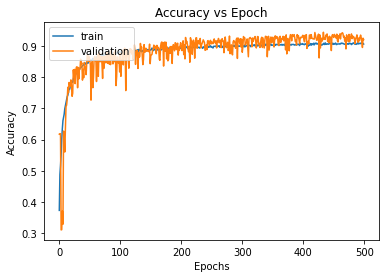

In [21]:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [22]:
test_loss, test_acc, acc = model.evaluate(train_images,train_keypoints, batch_size=BATCH_SIZE, verbose=2)

59/59 - 8s - loss: 0.4985 - mae: 0.5304 - acc: 0.9380


### Fit on model on full dataset

In [23]:
# %%time

# # Modify ModelCheckpoint callback to save model with best train mae to disk (instead of best validation mae)
# checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='mae', verbose=1, save_best_only=True, mode='min')
# model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])

## Predicting on Test Set

In [24]:
%%time
 
model = keras.models.load_model(model_name)
test_preds = model.predict(test_images)

CPU times: user 1.3 s, sys: 109 ms, total: 1.41 s
Wall time: 1.59 s


## Visualizing Test Predictions

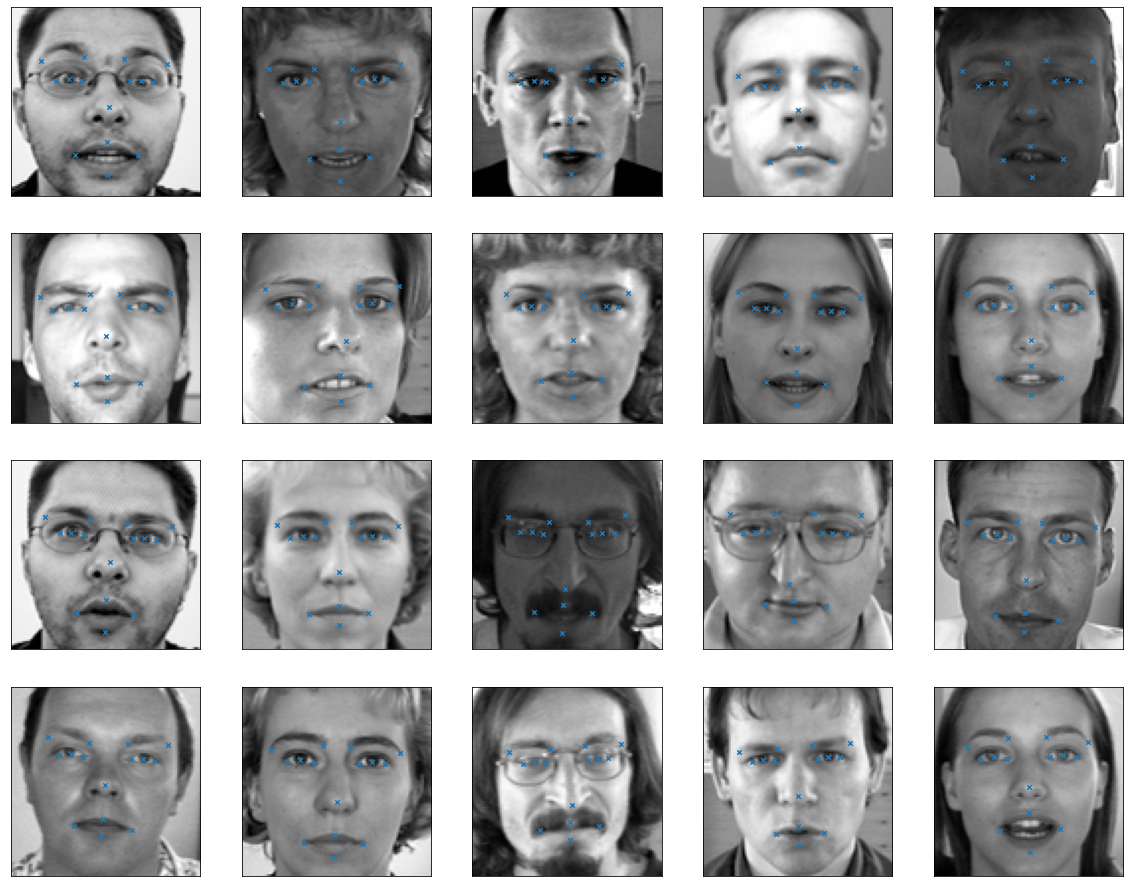

In [25]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")
plt.show()

## Generating Submission File

In [26]:
feature_names = list(Id_data['FeatureName'])
image_ids = list(Id_data['ImageId']-1)
row_ids = list(Id_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('data/{}submission.csv'.format(subname),index = False)